In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = ["SimHei"]
from utils import *

# 1.数据预处理

In [2]:
def load_data(train_df, test_df):
    # 训练数据处理
    train_labels = train_df.iloc[:, 0].values
    train_images = train_df.iloc[:, 1:].values.reshape(-1, 28, 28, 1)
    
    # 测试数据处理
    test_labels = test_df.iloc[:, 0].values
    test_images = test_df.iloc[:, 1:].values.reshape(-1, 28, 28, 1)
    
    return (train_images, train_labels), (test_images, test_labels)

##  1.1加载数据

In [3]:

train = pd.read_csv("./dataset/fashion-mnist_train.csv")
test = pd.read_csv("./dataset/fashion-mnist_test.csv") 
(train_images, train_labels), (test_images, test_labels) = load_data(train,test)

In [4]:
# 像素值归一化
train_images = train_images / 255.0  # normalize pixel values
test_images = test_images / 255.0

In [5]:
train_images.shape,train_labels.shape

((60000, 28, 28, 1), (60000,))

## 1.2创建验证集

In [6]:
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, 
    test_size=0.2, 
    random_state=42,
    stratify=train_labels  # 保持类别分布
)

In [7]:
print("数据形状:")
print(f"训练集: {train_images.shape} 标签: {train_labels.shape}")
print(f"验证集: {val_images.shape} 标签: {val_labels.shape}")
print(f"测试集: {test_images.shape} 标签: {test_labels.shape}")


数据形状:
训练集: (48000, 28, 28, 1) 标签: (48000,)
验证集: (12000, 28, 28, 1) 标签: (12000,)
测试集: (10000, 28, 28, 1) 标签: (10000,)


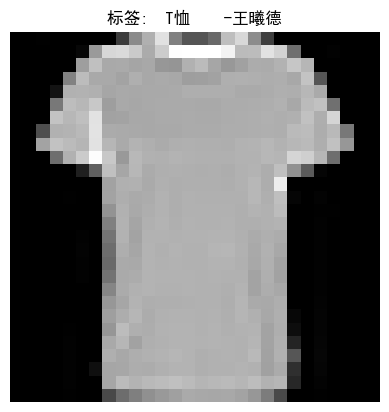

In [8]:
Named_labels = [' T恤', '裤子', '套衫', '连衣裙', '外套','凉鞋', '衬衫', '运动鞋', '包', '踝靴']
# 标签名称映射：用于将数字标签转换为人类可读的类别名称
index = 4
img = train_images[index].reshape(28, 28)#将一维像素向量重塑为 28×28 的二维图像（灰度图）
label = train_labels[index]
# 绘制图像并显示标签
plt.imshow(img, cmap='gray')
plt.title(f"标签: {Named_labels[label]}    -王曦德")
plt.axis('off')
plt.show()

In [9]:
# 修复数据增强器的创建方式
class Augmenter(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        # 一次性创建所有数据增强层（变量仅在此处创建一次）
        self.flip = tf.keras.layers.RandomFlip("horizontal")
        self.rotation = tf.keras.layers.RandomRotation(0.1)
        self.contrast = tf.keras.layers.RandomContrast(0.1)
        self.zoom = tf.keras.layers.RandomZoom(0.1)
    
    def call(self, inputs, training=True):  # 显式传递training参数
        x = self.flip(inputs, training=training)
        x = self.rotation(x, training=training)
        x = self.contrast(x, training=training)
        return self.zoom(x, training=training)

# 提前实例化增强器（关键修复点）
augmenter = Augmenter()

In [10]:
# 创建TensorFlow数据集
batch_size = 256

In [11]:
def create_dataset(images, labels, is_training=False):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_training:
        # 使用预创建的augmenter实例，并传递training参数
        ds = ds.shuffle(1000).map(
            lambda x, y: (augmenter(x, training=is_training), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

## 1.3构建数据管道

In [12]:
print("构建数据管道...")
train_ds = create_dataset(train_images, train_labels, is_training=True)
val_ds = create_dataset(val_images, val_labels)
test_ds = create_dataset(test_images, test_labels)
print("数据管道构建完成！")

构建数据管道...
数据管道构建完成！


# 2. 神经网络模型定义

In [13]:
# %%
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 26, 26, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 11, 11, 64)        256       
 chNormalization)                                                
                                                        

## 2.1学习率调度器

In [14]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.95
)

## 2.2编译模型

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## 2.3回调函数

In [16]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

## 2.4执行训练

In [17]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
188/188 [==============================] - 38s 188ms/step - loss: 0.8774 - accuracy: 0.6884 - val_loss: 2.2476 - val_accuracy: 0.2890
Epoch 2/20
188/188 [==============================] - 36s 192ms/step - loss: 0.6281 - accuracy: 0.7696 - val_loss: 0.9322 - val_accuracy: 0.6598
Epoch 3/20
188/188 [==============================] - 36s 190ms/step - loss: 0.5629 - accuracy: 0.7957 - val_loss: 0.4513 - val_accuracy: 0.8325
Epoch 4/20
188/188 [==============================] - 36s 192ms/step - loss: 0.5173 - accuracy: 0.8139 - val_loss: 0.4412 - val_accuracy: 0.8322
Epoch 5/20
188/188 [==============================] - 35s 189ms/step - loss: 0.4940 - accuracy: 0.8211 - val_loss: 0.4514 - val_accuracy: 0.8370
Epoch 6/20
188/188 [==============================] - 36s 189ms/step - loss: 0.4703 - accuracy: 0.8323 - val_loss: 0.3977 - val_accuracy: 0.8523
Epoch 7/20
188/188 [==============================] - 35s 186ms/step - loss: 0.4532 - accuracy: 0.8386 - val_loss: 0.3791 - val_ac

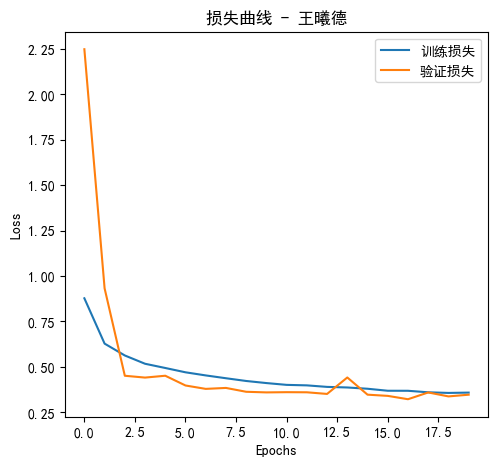

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.title('损失曲线 - 王曦德', fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

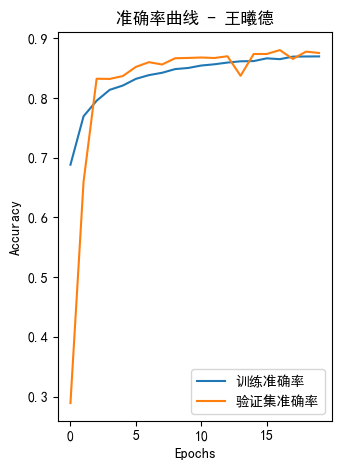

In [19]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='训练准确率')
plt.plot(history.history['val_accuracy'], label='验证集准确率')
plt.title('准确率曲线 - 王曦德', fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 2.5测试集评估

In [20]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"\n测试集准确率: {test_acc:.4f}")

40/40 [==============================] - 2s 48ms/step - loss: 0.3397 - accuracy: 0.8724

测试集准确率: 0.8724


## 2.6预测示例

In [21]:
sample_images = test_images[:5]
predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 318ms/step


In [22]:
class_names = [' T恤', '裤子', '套衫', '连衣裙', '外套','凉鞋', '衬衫', '运动鞋', '包', '踝靴']

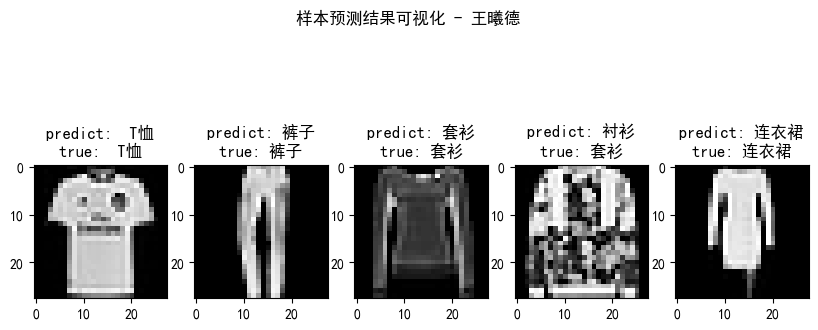

In [23]:
plt.figure(figsize=(10,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    class_names = [' T恤', '裤子', '套衫', '连衣裙', '外套','凉鞋', '衬衫', '运动鞋', '包', '踝靴']
    plt.imshow(sample_images[i].squeeze(), cmap='gray')
    plt.title(f"predict: {class_names[predicted_labels[i]]}\ntrue: {class_names[test_labels[i]]}")
    plt.axis('on')
plt.suptitle("样本预测结果可视化 - 王曦德", y=1.05)
plt.show()

# 3随机森林模型构建

## 3.1特征提取

In [24]:
feature_extractor = tf.keras.Model(
    inputs=model.input,
    outputs=model.layers[-3].output  # 提取全连接层前的特征
)

In [25]:
#特征提取函数
def extract_features(dataset):
    features = []
    labels = []
    for images, lbls in dataset.unbatch().batch(1000):
        features.append(feature_extractor.predict(images, verbose=0))
        labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

In [26]:
# 提取特征
print("正在提取训练特征...")
train_features, train_labels_rf = extract_features(train_ds)
print("正在提取测试特征...")
test_features, test_labels_rf = extract_features(test_ds)

正在提取训练特征...
正在提取测试特征...


## 3.2训练随机森林

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    n_jobs=-1,
    random_state=42
)
rf.fit(train_features, train_labels_rf)

RandomForestClassifier(max_depth=15, n_estimators=200, n_jobs=-1,
                       random_state=42)

# 4.结果分析

In [28]:
rf_preds = rf.predict(test_features)
rf_acc = accuracy_score(test_labels_rf, rf_preds)

print("\n模型对比结果:")
print(f"- nerualnetworks_accuracy: {test_acc:.4f}")
print(f"- randomforestaccuracy: {rf_acc:.4f}")


模型对比结果:
- nerualnetworks_accuracy: 0.8724
- randomforestaccuracy: 0.8756


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

## 4.1预测并计算指标

In [30]:
rf_preds = rf.predict(test_features)
rf_acc = accuracy_score(test_labels_rf, rf_preds)
rf_recall = recall_score(test_labels_rf, rf_preds, average='weighted')
rf_f1 = f1_score(test_labels_rf, rf_preds, average='weighted')

In [31]:
# 获取神经网络预测结果用于对比
nn_preds = model.predict(test_ds)
nn_preds_labels = np.argmax(nn_preds, axis=1)
nn_acc = test_acc  # 使用之前计算的准确率
nn_recall = recall_score(test_labels, nn_preds_labels, average='weighted')
nn_f1 = f1_score(test_labels, nn_preds_labels, average='weighted')

40/40 [==============================] - 2s 52ms/step


In [32]:
# 打印详细对比结果
print("\n模型对比结果:")
print(f"- 神经网络准确率: {nn_acc:.4f}, 召回率: {nn_recall:.4f}, F1值: {nn_f1:.4f}")
print(f"- 随机森林准确率: {rf_acc:.4f}, 召回率: {rf_recall:.4f}, F1值: {rf_f1:.4f}")


模型对比结果:
- 神经网络准确率: 0.8724, 召回率: 0.8724, F1值: 0.8727
- 随机森林准确率: 0.8756, 召回率: 0.8756, F1值: 0.8768


In [33]:
# 打印分类报告
print("\n神经网络分类报告:")
print(classification_report(test_labels, nn_preds_labels, target_names=class_names))


神经网络分类报告:
              precision    recall  f1-score   support

          T恤       0.77      0.86      0.81      1000
          裤子       0.98      0.98      0.98      1000
          套衫       0.90      0.73      0.80      1000
         连衣裙       0.94      0.85      0.89      1000
          外套       0.77      0.85      0.81      1000
          凉鞋       0.97      0.95      0.96      1000
          衬衫       0.62      0.63      0.62      1000
         运动鞋       0.90      0.96      0.93      1000
           包       0.95      0.98      0.96      1000
          踝靴       0.97      0.93      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



In [34]:
print("\n随机森林分类报告:")
print(classification_report(test_labels_rf, rf_preds, target_names=class_names))


随机森林分类报告:
              precision    recall  f1-score   support

          T恤       0.81      0.84      0.82      1000
          裤子       0.99      0.98      0.99      1000
          套衫       0.87      0.79      0.82      1000
         连衣裙       0.89      0.90      0.89      1000
          外套       0.84      0.77      0.81      1000
          凉鞋       0.97      0.95      0.96      1000
          衬衫       0.61      0.69      0.65      1000
         运动鞋       0.92      0.92      0.92      1000
           包       0.97      0.98      0.97      1000
          踝靴       0.93      0.95      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [35]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline 

In [36]:
# 生成预测结果
print("正在生成神经网络预测标签...")
nn_preds = model.predict(test_ds)
nn_pred_labels = np.argmax(nn_preds, axis=1)

正在生成神经网络预测标签...
40/40 [==============================] - 2s 52ms/step


## 4.2保存预测结果到CSV

In [37]:
pred_df = pd.DataFrame({
    "真实标签": test_labels,
    "预测标签": nn_pred_labels,
    "是否正确": ['True' if true == pred else 'False' for true, pred in zip(test_labels, nn_pred_labels)]  # 修改为字符串列表格式
})

# 保存到指定路径，使用UTF-8-sig编码避免Excel中文乱码[1,8](@ref)
pred_df.to_csv(
    "./预测结果/Random-Forest_results.csv",  # 使用目录结构组织文件[1](@ref)
    index=False,                    # 不保存行索引[1,2,3,5](@ref)
    encoding='utf-8-sig'            # 支持Excel中文兼容[1,8](@ref)
)

## 4.3结果指标可视化

In [38]:
# 生成混淆矩阵
cm = confusion_matrix(test_labels, nn_pred_labels)

In [39]:
# 自定义可视化函数
def plot_confusion_matrix(cm, classes, title='混淆矩阵'):
    plt.figure(figsize=(12, 10))
    
    # 使用imshow显示矩阵
    im = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    
    # 添加文本标签
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    # 坐标轴设置
    plt.title(f'{title} - 王曦德', fontsize=14)
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes, rotation=0)
    plt.xlabel('预测标签')
    plt.ylabel('真实标签')
    
    plt.tight_layout()
    plt.show()

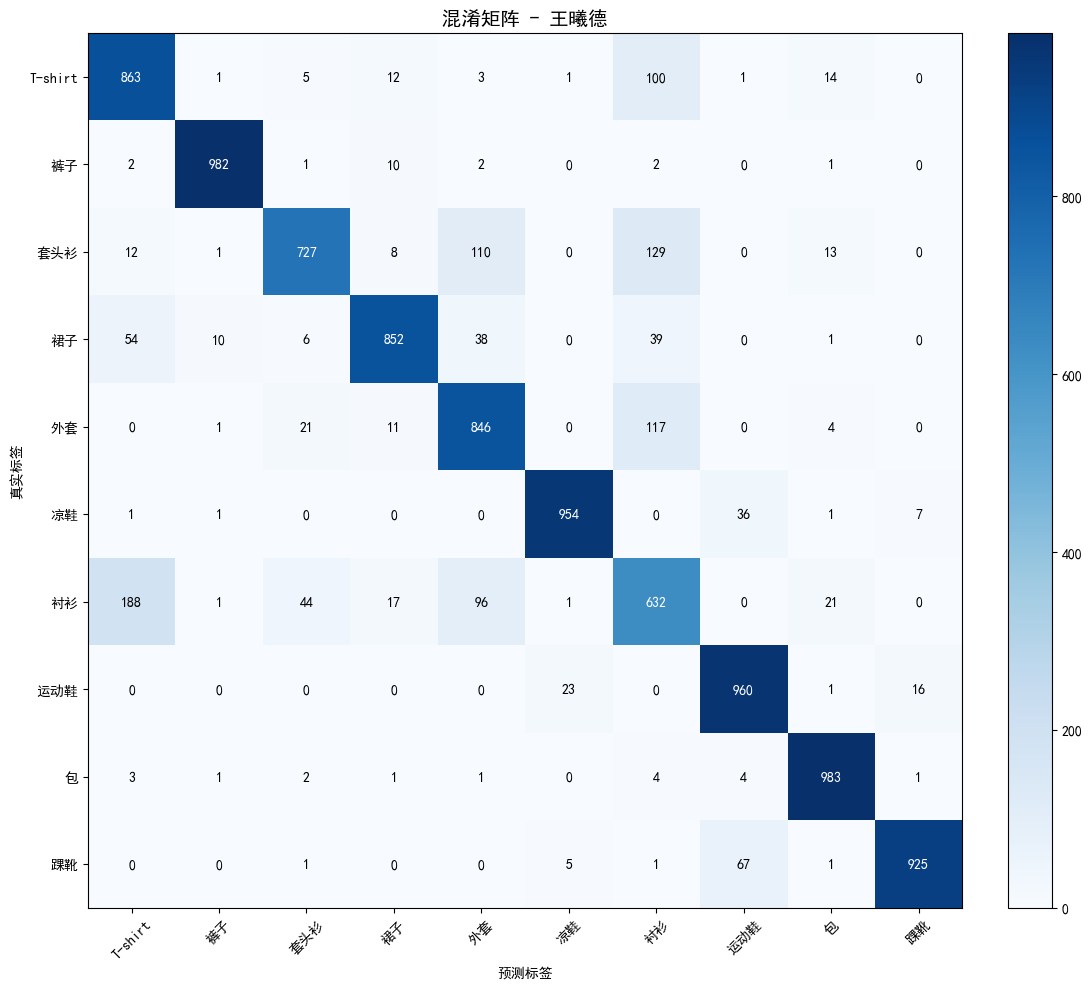

In [40]:
# 执行可视化
class_names = ['T-shirt', '裤子', '套头衫', '裙子', '外套',
               '凉鞋', '衬衫', '运动鞋', '包', '踝靴']
plot_confusion_matrix(cm, class_names)

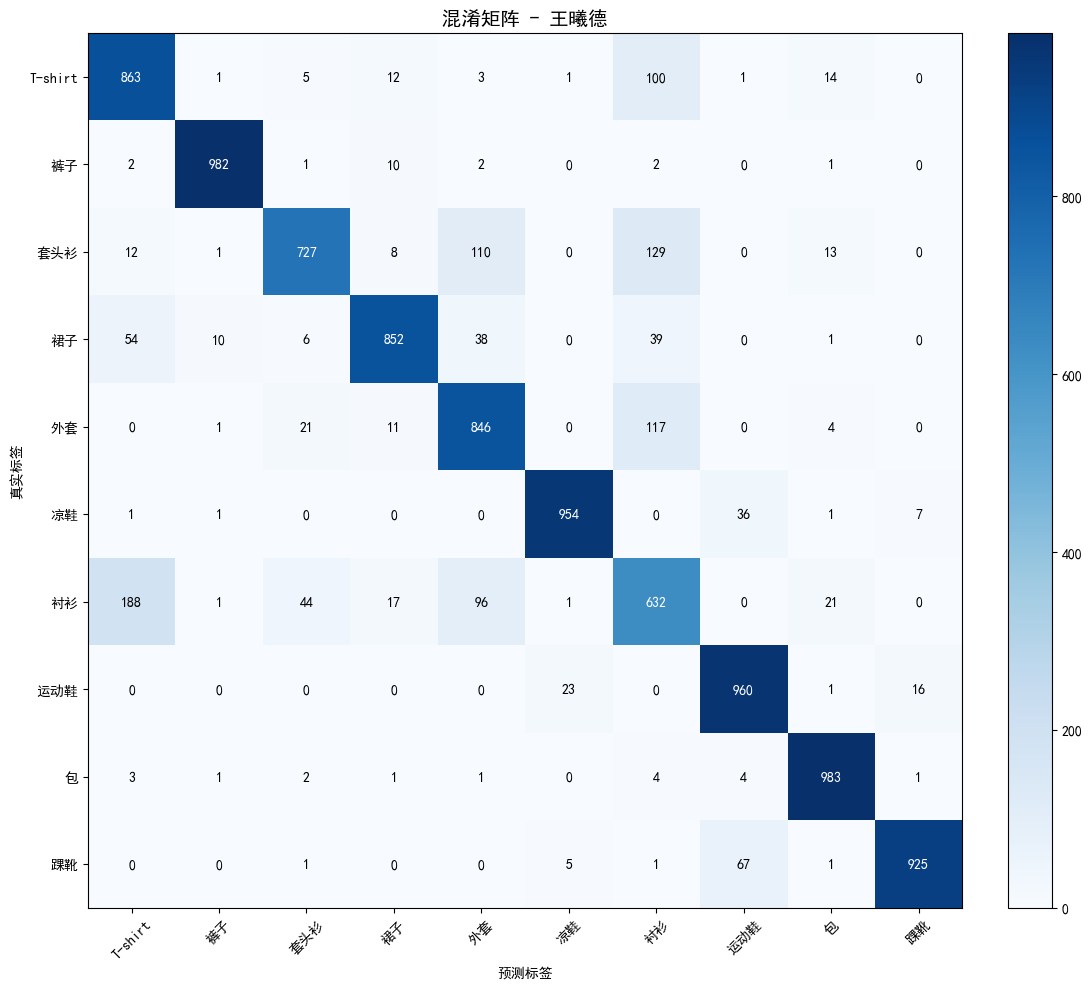

In [41]:
# 执行可视化
class_names = ['T-shirt', '裤子', '套头衫', '裙子', '外套',
               '凉鞋', '衬衫', '运动鞋', '包', '踝靴']
plot_confusion_matrix(cm, class_names)

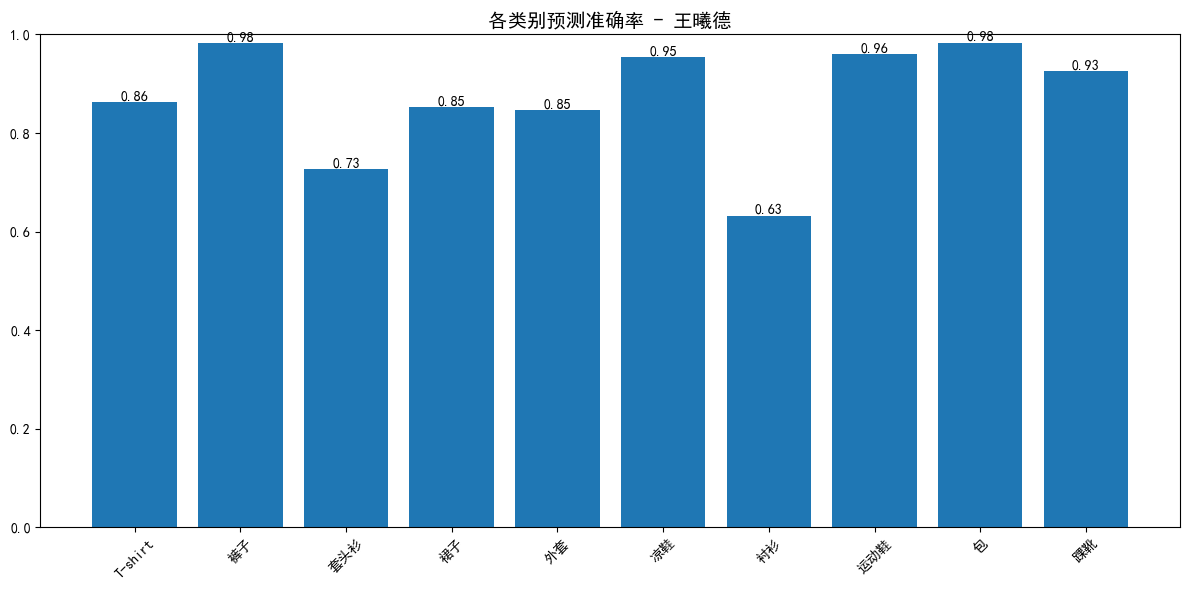

In [42]:
# 加载保存的预测结果
analysis_df = pd.read_csv("预测结果对比.csv")

# 生成类别准确率报告
class_acc = analysis_df.groupby('真实标签')['是否正确'].mean().reset_index()
class_acc.columns = ['类别', '准确率']

# 可视化准确率分布
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(class_names)), class_acc['准确率'], tick_label=class_names)
plt.title('各类别预测准确率 - 王曦德', fontsize=14)
plt.ylim(0, 1.0)
plt.xticks(rotation=45)

# 在柱子上添加数值标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

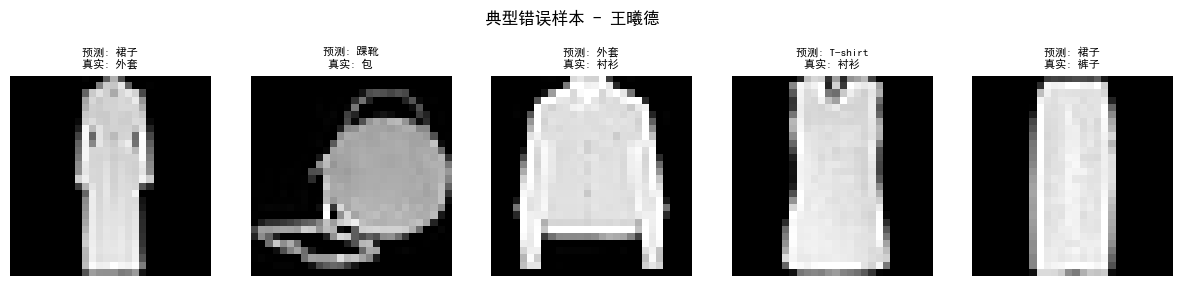

In [43]:
# 显示错误样本示例
error_samples = analysis_df[analysis_df['是否正确'] == False].sample(5)
plt.figure(figsize=(15, 3))
for idx, (i, row) in enumerate(error_samples.iterrows()):
    plt.subplot(1, 5, idx+1)
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    plt.title(f"预测: {class_names[row['预测标签']]}\n真实: {class_names[row['真实标签']]}", 
              fontsize=8)
    plt.axis('off')
plt.suptitle('典型错误样本 - 王曦德', y=1.05)
plt.show()

In [44]:
# 获取随机森林特征重要性
feature_importances = rf.feature_importances_

In [45]:
# 可视化前20个重要特征
plt.figure(figsize=(12, 6))
sorted_idx = np.argsort(feature_importances)[::-1][:20]  # 取前20个最重要的特征

<Figure size 1200x600 with 0 Axes>

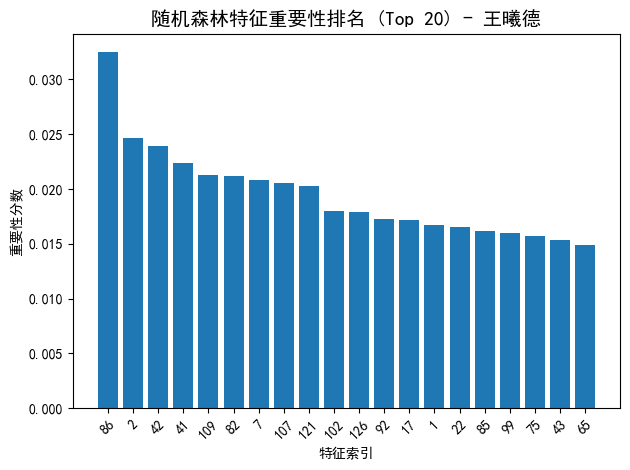

In [46]:
plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.xticks(range(len(sorted_idx)), sorted_idx, rotation=45)
plt.title('随机森林特征重要性排名 (Top 20) - 王曦德', fontsize=14)
plt.xlabel('特征索引')
plt.ylabel('重要性分数')
plt.tight_layout()
plt.show()

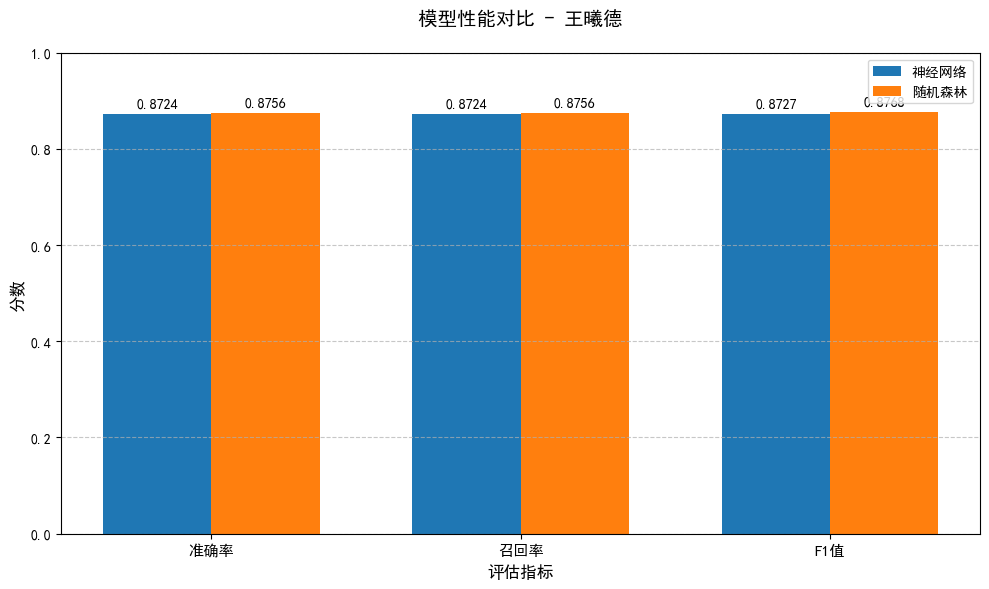

In [47]:
# 确保在 Notebook 开头设置正确的后端
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# 模型性能数据
metrics = ['准确率', '召回率', 'F1值']
nn_scores =[nn_acc, nn_recall, nn_f1]  # 神经网络得分
rf_scores =[rf_acc, rf_recall, rf_f1]  # 随机森林得分

# 创建图形和坐标轴对象
fig, ax = plt.subplots(figsize=(10, 6))  # 明确创建 fig 和 ax

# 绘图参数
x = np.arange(len(metrics))
width = 0.35

# 绘制柱状图
rects1 = ax.bar(x - width/2, nn_scores, width, label='神经网络', color='#1f77b4')
rects2 = ax.bar(x + width/2, rf_scores, width, label='随机森林', color='#ff7f0e')

# 添加文本标签的函数
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3点垂直偏移
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)

# 调用标签函数
autolabel(rects1)
autolabel(rects2)

# 设置图表属性 - 添加所有缺失的标签
ax.set_title('模型性能对比 - 王曦德', fontsize=14, pad=20)
ax.set_ylabel('分数', fontsize=12)
ax.set_xlabel('评估指标', fontsize=12)  # 添加X轴标签
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)  # 设置X轴刻度标签
ax.set_ylim(0, 1.0)  # 设置Y轴范围0-1.0
ax.legend(loc='upper right', frameon=True)  # 添加图例
ax.grid(axis='y', linestyle='--', alpha=0.7)  # 添加水平网格线

# 调整布局并显示
plt.tight_layout()
plt.show()